<img src = "https://freepngimg.com/download/python_logo/7-2-python-logo-free-download-png-thumb.png" width="50"> </p>
*Python 3.10.2*
***
## <font size="5">*Alexander A. Nazarov, 2022*
# <center> <font size="6"> ***Расчет и анализ корреляционного отношения средствами Python </p>Calculation and analysis of the correlation ratio using Python***
***

In [43]:
import time
start_time = time.time()

Подключение модулей и библиотек:

In [44]:
# Стандартные модули и библиотеки

import os    # загрузка модуля для работы с операционной системой
import sys
import platform
print('{:<35}{:^0}'.format("Текущая версия Python: ", platform.python_version()), '\n')

import math
from math import *    # подключаем все содержимое модуля math, используем без псевдонимов

import numpy as np
#print ("Текущая версия модуля numpy: ", np.__version__)
print('{:<35}{:^0}'.format("Текущая версия модуля numpy: ", np.__version__))
from numpy import nan

import scipy as sci
print('{:<35}{:^0}'.format("Текущая версия модуля scipy: ", sci.__version__))
import scipy.stats as sps

import pandas as pd
print('{:<35}{:^0}'.format("Текущая версия модуля pandas: ", pd.__version__))

import matplotlib as mpl
print('{:<35}{:^0}'.format("Текущая версия модуля matplotlib: ", mpl.__version__))
import matplotlib.pyplot as plt

import seaborn as sns
print('{:<35}{:^0}'.format("Текущая версия модуля seaborn: ", sns.__version__))

import statsmodels as sm
print('{:<35}{:^0}'.format("Текущая версия модуля statsmodels: ", sm.__version__))

import statistics as stat    # module 'statistics' has no attribute '__version__'

# Настройки numpy
np.set_printoptions(precision = 4, floatmode='fixed')

# Настройки Pandas
pd.set_option('display.max_colwidth', None)    # текст в ячейке отражался полностью вне зависимости от длины
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Настройки seaborn
sns.set_style("darkgrid")
sns.set_context(context='paper', font_scale=1, rc=None)    # 'paper', 'notebook', 'talk', 'poster', None

# Настройки Mathplotlib
f_size = 8    # пользовательская переменная для задания базового размера шрифта
plt.rcParams['figure.titlesize'] = f_size + 12    # шрифт заголовка
plt.rcParams['axes.titlesize'] = f_size + 10      # шрифт заголовка
plt.rcParams['axes.labelsize'] = f_size + 6       # шрифт подписей осей
plt.rcParams['xtick.labelsize'] = f_size + 4      # шрифт подписей меток
plt.rcParams['ytick.labelsize'] = f_size + 4
plt.rcParams['legend.fontsize'] = f_size + 6      # шрифт легенды

Текущая версия Python:             3.10.2 

Текущая версия модуля numpy:       1.22.2
Текущая версия модуля scipy:       1.8.0
Текущая версия модуля pandas:      1.4.1
Текущая версия модуля matplotlib:  3.5.1
Текущая версия модуля seaborn:     0.11.2
Текущая версия модуля statsmodels: 0.13.2


Прочие настройки:

In [45]:
# Константы
INCH = 25.4    # мм/дюйм
DecPlace = 5    # number of decimal places - число знаков после запятой

Доверительная вероятность и уровень значимости:

In [46]:
p_level = 0.95
a_level = 1 - p_level   

### <center> <u> <font size="5"> ***ПОСТАНОВКА ЗАДАЧИ***

При статистическом анализе зависимостей между количественными переменными возникают ситуации, когда представляет интерес расчет и анализ такого показателя как **корреляционное отношение (η)**.

Данный показатель незаслуженно обойден вниманием в большинстве доступных для пользователей математических пакетов. 

В данном разборе рассмотрим способы расчета и анализа **η** средствами **Python**.

Не будем углубляться в теорию (про **η** достаточно подробно написано, например, в [1, с.73], [2, с.412], [3, с.609]), но вспомним основные свойства **η**:
1. **η** характеризует степень тесноты **любой** корреляционной связи (как линейной, так и нелинейной), в отличие от коэффициента корреляции Пирсона **r**, который характеризует тесноту только **линейной** связи. Условие **r=0** означает отсутствие линейной корреляционной связи между величинами, но при этом между ними может существовать нелинейная корреляционная связь (**η>0**).
2. **η** принимает значения от 0 до 1; при **η=0** корреляционная связь отсутствует, при **η=1** связь считается функциональной; степень тесноты связи можно оценивать по различным общепринятым шкалам, например, по шкале Чеддока и др.
3. Величина **η²** характеризует долю вариации, объясненной корреляционной связью между рассматриваемыми переменными.
4. **η** не может быть меньше абсолютной величины **r**: **η ≥ |r|**.
5. **η** несимметрично по отношению к исследуемым переменным, то есть **η<font size="1">XY<font size="4"> ≠ η<font size="1">YX<font size="4">**.
6. Для расчета **η** необходимо иметь эмпирические данные эксперимента с повторностями; если же мы имеем просто два набора значений переменных **X** и **Y**, то данные нужно группировать. Этот вывод, в общем-то, очевиден - если предпринять попытку рассчитать **η** по негруппированным данным, получим результат **η=1**.
   
Группировка данных для расчета **η** заключается в разбиении области значений переменных **X** и **Y** на интервалы, подсчет частот попадания данных в интервалы и формирование **корреляционной таблицы**.

Итак, перейдем к расчетам.

### <center> <u> <font size="5"> ***ФОРМИРОВАНИЕ ИСХОДНЫХ ДАННЫХ***

В качестве исходных данных рассмотрим зависимость расхода **среднемесячного расхода топлива автомобиля (л/100 км) (FuelFlow)** от **среднемесячного пробега (км) (Mileage)**.

Загрузим исходные данные из csv-файла.

In [47]:
fuel_df = pd.read_csv(
    filepath_or_buffer='data/fuel_df.csv',
    sep=';',
    index_col='Number')
dataset_df = fuel_df.copy()    # создаем копию исходной таблицы для работы
display(dataset_df.head())
dataset_df.info()

,Date,Mileage,Temperature,FuelFlow
Number,,,,
0,2018-06-30,696.8000,15.2000,10.0800
1,2018-07-31,2751.5000,19.4000,8.9100
2,2018-08-31,1308.7000,17.9000,7.4500
3,2018-09-30,837.4000,12.7000,9.1700
4,2018-10-31,2130.8000,5.6000,8.2000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 49
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         49 non-null     object 
 1   Mileage      49 non-null     float64
 2   Temperature  49 non-null     float64
 3   FuelFlow     49 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.9+ KB


Среднемесячный пробег (км):

In [48]:
X = np.array(dataset_df['Mileage'])
print(X)

[ 696.8000 2751.5000 1308.7000  837.4000 2130.8000  704.0000  666.3000
  840.5000  642.0000  900.0000  642.0000 1130.0000  740.0000 1025.0000
 1009.0000 2187.0000 2069.0000  377.0000  393.0000  600.0000  791.0000
  475.0000  265.0000 1334.0000 1079.0000 1229.0000 1335.0000   37.0000
  235.0000  803.0000  575.0000  558.0000  792.0000 1515.0000  878.0000
  733.0000 1379.0000 1534.0000 1025.0000 1236.0000  602.0000 1032.0000
  960.0000  593.0000  976.0000  800.0000  838.0000  971.0000 1114.0000]


Среднемесячный расход топлива автомобиля (л/100 км):

In [49]:
Y = np.array(dataset_df['FuelFlow'])
print(Y)

[10.0800  8.9100  7.4500  9.1700  8.2000 10.3000 12.0100 10.1700 11.4900
  9.7200  9.7400  8.8500  8.4500  9.1500  8.6700  7.7200  7.7300 11.6000
 10.9500 11.0400  9.9600 10.8500  8.9600  6.0800 10.2600  9.5700  9.1800
 16.8900 12.7700 10.4300 11.3000 12.9900  9.9400  7.9600  8.9700  9.7200
  8.9700  8.5600 10.0000  8.1900 11.0000  7.8700 10.0300 11.1700  9.0900
  9.6900  8.6500  9.9100  9.6500]


Для удобства дальнейшей работы сформируем сформируем отдельный DataFrame из двух переменных - **X** и **Y**:

In [50]:
data_XY_df = pd.DataFrame({
    'X': X,
    'Y': Y})
display(data_XY_df.head())

,X,Y
0,696.8000,10.0800
1,2751.5000,8.9100
2,1308.7000,7.4500
3,837.4000,9.1700
4,2130.8000,8.2000


Настройка заголовков отчета:

In [51]:
# Общий заголовок проекта
Task_Project = "Расчет и анализ корреляционного отношения средствами Python"
# Заголовок, фиксирующий момент времени
AsOfTheDate = ""
# Заголовок раздела проекта
Task_Theme = "Анализ расхода топлива автомобиля"
# Общий заголовок проекта для графиков
Title_String = f"{Task_Project}\n{AsOfTheDate}"
# Наименования переменных
Variable_Name_X = "Среднемесячный пробег (км)"
Variable_Name_Y = "Среднемесячный расход топлива автомобиля (л/100 км)"

### <center> <u> <font size="5"> ***ВИЗУАЛИЗАЦИЯ И ПЕРВИЧНАЯ ОБРАБОТКА ДАННЫХ***

Предварительно отсеем аномальные значения (выбросы). Подробно не будем останавливаться на этой процедуре, она не является целью данного разбора.

In [52]:
mask1 = data_XY_df['X'] > 200
mask2 = data_XY_df['X'] < 2000
data_XY_df = data_XY_df[mask1 & mask2]

X = np.array(data_XY_df['X'])
Y = np.array(data_XY_df['Y'])

Описательная статистика исходных данных:

In [53]:
data_XY_df.describe()

,X,Y
count,44.0000,44.0000
mean,867.4705,9.7855
std,318.5176,1.3686
min,235.0000,6.0800
25%,642.0000,8.9675
50%,837.7000,9.7300
75%,1043.7500,10.5350
max,1534.0000,12.9900


Выполним визуализацию исходных данных:

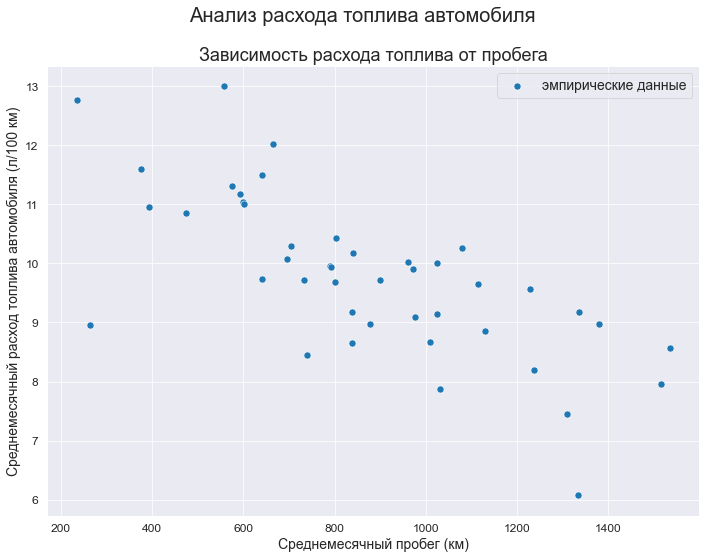

In [54]:
fig, axes = plt.subplots(figsize=(297/INCH, 210/INCH))
fig.suptitle(Task_Theme)
axes.set_title('Зависимость расхода топлива от пробега')
data_df = data_XY_df
sns.scatterplot(
    data=data_df,
    x='X', y='Y',
    label='эмпирические данные',
    s=50,
    ax=axes)
axes.set_xlabel(Variable_Name_X)
axes.set_ylabel(Variable_Name_Y)
#axes.tick_params(axis="x", labelsize=f_size+4)
#axes.tick_params(axis="y", labelsize=f_size+4)
#axes.legend(prop={'size': f_size+6})
plt.show()
fig.savefig('graph/scatterplot_XY_sns.png', orientation = "portrait", dpi = 300)

Для визуальной оценки выборочных данных построим гистограммы и коробчатые диаграммы:

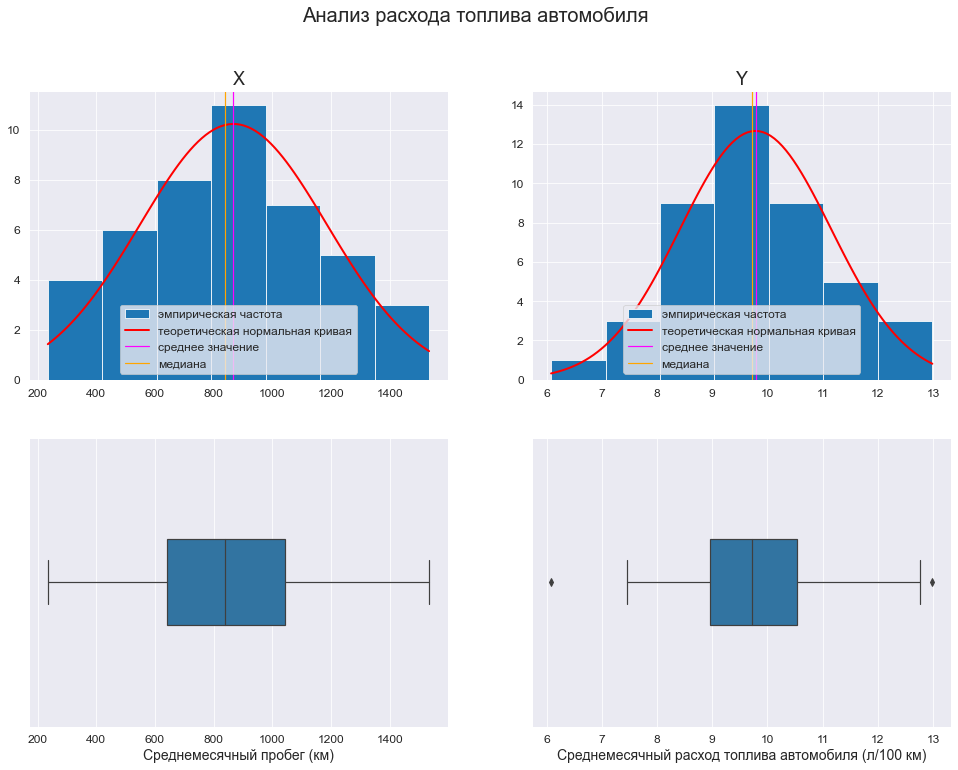

In [55]:
fig = plt.figure(figsize=(420/INCH, 297/INCH))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)
fig.suptitle(Task_Theme)
ax1.set_title('X')
ax2.set_title('Y')

# инициализация данных
data_df = data_XY_df
X_mean = data_df['X'].mean()
X_std = data_df['X'].std(ddof = 1)
Y_mean = data_df['Y'].mean()
Y_std = data_df['Y'].std(ddof = 1)
bins_hist = 'sturges'    # выбор числа интервалов ('auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', 'sqrt')

# данные для графика плотности распределения X
xmin = np.amin(data_df['X'])
xmax = np.amax(data_df['X'])
nx = 100
hx = (xmax - xmin)/(nx - 1)
x1 = np.linspace(xmin, xmax, nx)
xnorm1 = sps.norm.pdf(x1, X_mean, X_std)
kx = len(np.histogram(X, bins=bins_hist, density=False)[0])
xnorm2 = xnorm1*len(X)*(xmax-xmin)/kx

# данные для графика плотности распределения Y
ymin = np.amin(Y)
ymax = np.amax(Y)
ny = 100
hy = (ymax - ymin)/(ny - 1)
y1 = np.linspace(ymin, ymax, ny)
ynorm1 = sps.norm.pdf(y1, Y_mean, Y_std)
ky = len(np.histogram(Y, bins=bins_hist, density=False)[0])
ynorm2 = ynorm1*len(Y)*(ymax-ymin)/ky

# гистограмма распределения X
ax1.hist(
    data_df['X'],
    bins=bins_hist,
    density=False,
    histtype='bar',    # 'bar', 'barstacked', 'step', 'stepfilled'
    orientation='vertical',   # 'vertical', 'horizontal'
    color = "#1f77b4",
    label='эмпирическая частота')
ax1.plot(
    x1, xnorm2,
    linestyle = "-",
    color = "r",
    linewidth = 2,
    label = 'теоретическая нормальная кривая')
ax1.axvline(X_mean, color='magenta', label = 'среднее значение')
ax1.axvline(np.median(data_df['X']), color='orange', label = 'медиана')
ax1.legend(fontsize = f_size+4)

# гистограмма распределения Y
ax2.hist(
    data_df['Y'],
    bins=bins_hist,
    density=False,
    histtype='bar',    # 'bar', 'barstacked', 'step', 'stepfilled'
    orientation='vertical',   # 'vertical', 'horizontal'
    color = "#1f77b4",
    label='эмпирическая частота')    
ax2.plot(
    y1, ynorm2,
    linestyle = "-",
    color = "r",
    linewidth = 2,
    label = 'теоретическая нормальная кривая')
ax2.axvline(Y_mean, color='magenta', label = 'среднее значение')
ax2.axvline(np.median(data_df['Y']), color='orange', label = 'медиана')
ax2.legend(fontsize = f_size+4)

# коробчатая диаграмма X
sns.boxplot(
    #data=corn_yield_df,
    x=data_df['X'],
    orient='h',
    width=0.3,
    ax=ax3)

# коробчатая диаграмма Y
sns.boxplot(
    #data=corn_yield_df, 
    x=data_df['Y'], 
    orient='h', 
    width=0.3, 
    ax=ax4)

# подписи осей 
ax3.set_xlabel(Variable_Name_X)
ax4.set_xlabel(Variable_Name_Y)

plt.show()
fig.savefig('graph/scatterplot_boxplot_X_Y_sns.png', orientation = "portrait", dpi = 300)

Перед тем, как приступать к дальнейшим расчетам, проверим исходные данные на соответствие нормальному закону распределения по критерию Шапиро-Уилка:

In [56]:
# функция для обработки реализации теста Шапиро-Уилка
def Shapiro_Wilk_test(data):
    data = np.array(data)
    result = sci.stats.shapiro(data)
    s_calc = result.statistic    # расчетное значение статистики критерия
    a_calc = result.pvalue    # расчетный уровень значимости
    
    print(f"Расчетный уровень значимости: a_calc = {round(a_calc, DecPlace)}")
    print(f"Заданный уровень значимости: a_level = {round(a_level, DecPlace)}")
    
    if a_calc >= a_level:
        conclusion_ShW_test = f"Так как a_calc = {round(a_calc, DecPlace)} >= a_level = {round(a_level, DecPlace)}" + \
            ", то гипотеза о нормальности распределения по критерию Шапиро-Уилка ПРИНИМАЕТСЯ"
    else:
        conclusion_ShW_test = f"Так как a_calc = {round(a_calc, DecPlace)} < a_level = {round(a_level, DecPlace)}" + \
            ", то гипотеза о нормальности распределения по критерию Шапиро-Уилка ОТВЕРГАЕТСЯ"
    print(conclusion_ShW_test)

In [57]:
# проверка нормальности распределения переменной X
Shapiro_Wilk_test(X)

Расчетный уровень значимости: a_calc = 0.78034
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 0.78034 >= a_level = 0.05, то гипотеза о нормальности распределения по критерию Шапиро-Уилка ПРИНИМАЕТСЯ


In [58]:
# проверка нормальности распределения переменной Y
Shapiro_Wilk_test(Y)

Расчетный уровень значимости: a_calc = 0.86505
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 0.86505 >= a_level = 0.05, то гипотеза о нормальности распределения по критерию Шапиро-Уилка ПРИНИМАЕТСЯ


Итак, гипотеза о нормальном распределении исходных данных принимается, что позволяет нам в дальнейшем пользоваться статистическим инструментарием для интервального оценивания величины **η**, проверки гипотез и т.д.

Переходим собственно к расчету корреляционного отношения.

### <center> <u> <font size="5"> ***РАСЧЕТ И АНАЛИЗ КОРРЕЛЯЦИОННОГО ОТНОШЕНИЯ***

<u>1. Выполним группировку исходных данным по обоим признакам X и Y:</u>

Создадим новую переменную **matrix_XY_df** для работы с группированными данными:

In [59]:
matrix_XY_df = data_XY_df.copy()

Определим число интервалов группировки (воспользуемся формулой Стерджесса); при этом минимальное число интервалов должно быть не менее 2:

In [60]:
# объем выборки для переменных X и Y
n_X = len(X)
n_Y = len(Y)

# число интервалов группировки
group_int_number = lambda n: round (3.31*log(n_X, 10)+1) if round (3.31*log(n_X, 10)+1) >=2 else 2

K_X = group_int_number(n_X)
K_Y = group_int_number(n_Y)
print(f"Число интервалов группировки для переменной X: {K_X}")
print(f"Число интервалов группировки для переменной Y: {K_Y}")

Число интервалов группировки для переменной X: 6
Число интервалов группировки для переменной Y: 6


Выполним группировку данных средствами библиотеки **pandas**, для этого воспользуемся функцией **pandas.cut**. В результате получим новые признаки **cut_X** и **cut_X**, которые показывают, в какой из интервалов попадает конкретное значение **X** и **Y**. Полученные новые признаки добавим в DataFrame **matrix_XY_df**:

In [61]:
cut_X = pd.cut(X, bins=K_X)
cut_Y = pd.cut(Y, bins=K_Y)

matrix_XY_df['cut_X'] = cut_X
matrix_XY_df['cut_Y'] = cut_Y

display(matrix_XY_df.head())

,X,Y,cut_X,cut_Y
0,696.8000,10.0800,"(668.0, 884.5]","(9.535, 10.687]"
2,1308.7000,7.4500,"(1101.0, 1317.5]","(7.232, 8.383]"
3,837.4000,9.1700,"(668.0, 884.5]","(8.383, 9.535]"
5,704.0000,10.3000,"(668.0, 884.5]","(9.535, 10.687]"
6,666.3000,12.0100,"(451.5, 668.0]","(11.838, 12.99]"


Теперь мы можем получить корреляционную таблицу с помощью функции **pandas.crosstab**:

In [62]:
CorrTable_df = pd.crosstab(
    index=matrix_XY_df['cut_X'],
    columns=matrix_XY_df['cut_Y'],
    rownames=['cut_X'],
    colnames=['cut_Y'])

display(CorrTable_df)

# проверка правильности подсчета частот по интервалам
print(f"sum = {np.sum(np.array(CorrTable_df))}")

cut_Y,"(6.073, 7.232]","(7.232, 8.383]","(8.383, 9.535]","(9.535, 10.687]","(10.687, 11.838]","(11.838, 12.99]"
cut_X,,,,,,
"(233.701, 451.5]",0,0,1,0,2,1
"(451.5, 668.0]",0,0,0,1,6,2
"(668.0, 884.5]",0,0,4,8,0,0
"(884.5, 1101.0]",0,1,3,5,0,0
"(1101.0, 1317.5]",0,2,1,2,0,0
"(1317.5, 1534.0]",1,1,3,0,0,0


sum = 44


Функция **pandas.crosstab** также позволяет формировать более ровные и удобные для восприятия границы интервалов группировки путем задания их вручную. Для расчета **η** это принципиального значения не имеет, но в отдельных случаях может быть полезно.

Например, зададим вручную границы интервалов группировки для **X** и **Y**:

In [63]:
bins_X = pd.IntervalIndex.from_tuples([(200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, 1600)])
cut_X = pd.cut(X, bins=bins_X)

bins_Y = pd.IntervalIndex.from_tuples([(6.0, 7.0), (7.0, 8.0), (8.0, 9.0), (9.0, 10.0), (10.0, 11.0), (11.0, 12.0), (12.0, 13.0)])
cut_Y = pd.cut(X, bins=bins_Y)

CorrTable_df2 = pd.crosstab(
    index=pd.cut(X, bins=bins_X),
    columns=pd.cut(Y, bins=bins_Y),
    rownames=['cut_X'],
    colnames=['cut_Y'])
display(CorrTable_df2)

# проверка правильности подсчета частот по интервалам
print(f"sum = {np.sum(np.array(CorrTable_df2))}")

cut_Y,"(6.0, 7.0]","(7.0, 8.0]","(8.0, 9.0]","(9.0, 10.0]","(10.0, 11.0]","(11.0, 12.0]","(12.0, 13.0]"
cut_X,,,,,,,
"(200, 400]",0,0,1,0,1,1,1
"(400, 600]",0,0,0,0,1,3,1
"(600, 800]",0,0,1,5,3,1,1
"(800, 1000]",0,0,2,4,3,0,0
"(1000, 1200]",0,1,2,3,1,0,0
"(1200, 1400]",1,1,2,2,0,0,0
"(1400, 1600]",0,1,1,0,0,0,0


sum = 44


Есть и другой способ получения корреляционной таблицы - с помощью **pandas.pivot_table**:

In [64]:
matrix_XY_df.pivot_table(
    values=['Y'],
    index='cut_X',
    columns='cut_Y',
    aggfunc=len,
    fill_value=0)

Y                                                \
cut_Y            (6.073, 7.232] (7.232, 8.383] (8.383, 9.535] (9.535, 10.687]   
cut_X                                                                           
(233.701, 451.5]              0              0              1               0   
(451.5, 668.0]                0              0              0               1   
(668.0, 884.5]                0              0              4               8   
(884.5, 1101.0]               0              1              3               5   
(1101.0, 1317.5]              0              2              1               2   
(1317.5, 1534.0]              1              1              3               0   

                                                   
cut_Y            (10.687, 11.838] (11.838, 12.99]  
cut_X                                              
(233.701, 451.5]                2               1  
(451.5, 668.0]                  6               2  
(668.0, 884.5]                  0               0  
(884.5, 1101.0]                 0               0  
(1101.0, 1317.5]                0               0  
(1317.5, 1534.0]                0               0

<u>2. Выполним расчет корреляционного отношения:</u>

Для дальнейших расчетов приведем корреляционную таблицу к типу **numpy.ndarray**:

In [65]:
CorrTable_np = np.array(CorrTable_df)
print(CorrTable_np, type(CorrTable_np))

[[0 0 1 0 2 1]
 [0 0 0 1 6 2]
 [0 0 4 8 0 0]
 [0 1 3 5 0 0]
 [0 2 1 2 0 0]
 [1 1 3 0 0 0]] <class 'numpy.ndarray'>


Итоги корреляционной таблицы по строкам и столбцам:

In [66]:
# итоги по строкам
n_group_X = [np.sum(CorrTable_np[i]) for i in range(K_X)]
print(f"n_group_X = {n_group_X}")

# итоги по столбцам
n_group_Y = [np.sum(CorrTable_np[:,j]) for j in range(K_Y)]
print(f"n_group_Y = {n_group_Y}")

n_group_X = [4, 9, 12, 9, 5, 5]
n_group_Y = [1, 4, 12, 16, 8, 3]


Также нам необходимо получить среднегрупповые значения **X** и **Y** для каждой группы (интервала). При этом нужно помнить, что функция **pandas.crosstab** при группировании расширяет крайние диапазоны на 0.1% с каждой стороны, чтобы включить минимальное и максимальное значения.

Для доступа к данным - границам интервалов, полученным с помощью **pandas.cut** - существуют методы **right** и **left**:

In [67]:
# Среднегрупповые значения переменной X
Xboun_mean = [(CorrTable_df.index[i].left + CorrTable_df.index[i].right)/2 for i in range(K_X)]
Xboun_mean[0] = (np.min(X) + CorrTable_df.index[0].right)/2    # исправляем значения в крайних интервалах
Xboun_mean[K_X-1] = (CorrTable_df.index[K_X-1].left + np.max(X))/2
print(f"Xboun_mean = {Xboun_mean}")

# Среднегрупповые значения переменной Y
Yboun_mean = [(CorrTable_df.columns[j].left + CorrTable_df.columns[j].right)/2 for j in range(K_Y)]
Yboun_mean[0] = (np.min(Y) + CorrTable_df.columns[0].right)/2    # исправляем значения в крайних интервалах
Yboun_mean[K_Y-1] = (CorrTable_df.columns[K_Y-1].left + np.max(Y))/2
print(f"Yboun_mean = {Yboun_mean}", '\n')

Xboun_mean = [343.25, 559.75, 776.25, 992.75, 1209.25, 1425.75]
Yboun_mean = [6.656000000000001, 7.807499999999999, 8.959, 10.111, 11.2625, 12.414] 



Находим средневзевешенные значения **X** и **Y** для каждой группы:

In [68]:
Xmean_group = [np.sum(CorrTable_np[:,j] * Xboun_mean) / n_group_Y[j] for j in range(K_Y)]
print(f"Xmean_group = {Xmean_group}")

Ymean_group = [np.sum(CorrTable_np[i] * Yboun_mean) / n_group_X[i] for i in range(K_X)]
print(f"Ymean_group = {Ymean_group}")

Xmean_group = [1425.75, 1209.25, 992.75, 884.5, 505.625, 487.5833333333333]
Ymean_group = [10.974499999999999, 11.390444444444444, 9.727, 9.471055555555557, 8.9592, 8.2681]


Общая дисперсия **X** и **Y**:

In [69]:
Sum2_total_X = np.sum(n_group_X * (Xboun_mean - np.mean(X))**2)
print(f"Sum2_total_X = {Sum2_total_X}")

Sum2_total_Y = np.sum(n_group_Y * (Yboun_mean - np.mean(Y))**2)
print(f"Sum2_total_Y = {Sum2_total_Y}")

Sum2_total_X = 4335010.5225
Sum2_total_Y = 73.51576518181821


Межгрупповая дисперсия **X** и **Y** (дисперсия групповых средних):

In [70]:
Sum2_between_group_X = np.sum(n_group_Y * (Xmean_group - np.mean(X))**2)
print(f"Sum2_between_group_X = {Sum2_between_group_X}")

Sum2_between_group_Y = np.sum(n_group_X * (Ymean_group - np.mean(Y))**2)
print(f"Sum2_between_group_Y = {Sum2_between_group_Y}")

Sum2_between_group_X = 2452308.480833333
Sum2_between_group_Y = 44.695180237373734


Внутригрупповая дисперсия **X** и **Y** (возникает за счет других факторов - не связанных с другой переменной):

In [71]:
print(f"Sum2_within_group_X = {Sum2_total_X - Sum2_between_group_X}")
print(f"Sum2_within_group_Y = {Sum2_total_Y - Sum2_between_group_Y}")

Sum2_within_group_X = 1882702.041666667
Sum2_within_group_Y = 28.820584944444477


Эмпирическое корреляционное отношение:

In [72]:
corr_ratio_XY = sqrt(Sum2_between_group_Y / Sum2_total_Y)
print(f"corr_ratio_XY = {corr_ratio_XY}")

corr_ratio_YX = sqrt(Sum2_between_group_X / Sum2_total_X)
print(f"corr_ratio_YX = {corr_ratio_YX}")

corr_ratio_XY = 0.7797225699063492
corr_ratio_YX = 0.7521292387337751


Итак, мы получили результат - значение корреляционного отношения.

Оценим тесноту корреляционной связи по **шкале Чеддока**, для удобства создадим пользовательскую функцию:

In [73]:
def Cheddock_scale_check(r, name='r'):
    # задаем шкалу Чеддока
    Cheddock_scale = {
        f'no correlation (|{name}| <= 0.1)':    0.1,
        f'very weak (0.1 < |{name}| <= 0.2)':   0.2,
        f'weak (0.2 < |{name}| <= 0.3)':        0.3,
        f'moderate (0.3 < |{name}| <= 0.5)':    0.5,
        f'perceptible (0.5 < |{name}| <= 0.7)': 0.7,
        f'high (0.7 < |{name}| <= 0.9)':        0.9,
        f'very high (0.9 < |{name}| <= 0.99)':  0.99,
        f'functional (|{name}| > 0.99)':        1.0}
    
    r_scale = list(Cheddock_scale.values())
    for i, elem in enumerate(r_scale):
        if abs(r) <= elem:
            conclusion_Cheddock_scale = list(Cheddock_scale.keys())[i]
            break
    return conclusion_Cheddock_scale    

print(f"Оценка тесноты корреляции по шкале Чеддока: {Cheddock_scale_check(corr_ratio_XY, name=chr(951))}")

Оценка тесноты корреляции по шкале Чеддока: high (0.7 < |η| <= 0.9)


Шкала Чеддока изначально предназначалась для оценки тесноты линейно корреляционной связи (на основе коэффициента корреляции Пирсона **r**), но мы ее применим и для корреляционного отношения **η** (не забывая про свойство **η ≥ r**!). В выводе функции **Cheddock_scale_check** можно указать символ, обозначающий величину - аргумент **name=chr(951)** выводит **η** вместо **r**.

В современных исследованиях **шкала Чеддока** теряет популярность, в последние годы все чаще применяется **шкала Эванса** (в психосоциальных, медико-биологических и др.исследованиях) ( более подробно про шкалы Чеддока, Эванса и др. - см.[4]). Оценим тесноту корреляционной связи по **шкале Эванса**, для удобства также создадим пользовательскую функцию:

In [74]:
def Evans_scale_check(r, name='r'):
    # задаем шкалу Эванса
    Evans_scale = {
        f'very weak (|{name}| < 0.19)':         0.2,
        f'weak (0.2 < |{name}| <= 0.39)':       0.4,  
        f'moderate (0.4 < |{name}| <= 0.59)':   0.6,
        f'strong (0.6 < |{name}| <= 0.79)':     0.8,
        f'very strong (0.8 < |{name}| <= 1.0)': 1.0}
    
    r_scale = list(Evans_scale.values())
    for i, elem in enumerate(r_scale):
        if abs(r) <= elem:
            conclusion_Evans_scale = list(Evans_scale.keys())[i]
            break
    return conclusion_Evans_scale    

print(f"Оценка тесноты корреляции по шкале Эванса: {Evans_scale_check(corr_ratio_XY, name=chr(951))}")

Оценка тесноты корреляции по шкале Эванса: strong (0.6 < |η| <= 0.79)


Итак, степень тесноты корреляционной связи может быть оценена как **высокая** (по шкале Чеддока), **сильная** (по шкале Эванса).

<u>3. Проверка значимости корреляционного отношения:</u>

Рассмотрим нулевую гипотезу:

    H0: ηXY = 0
    H1: ηXY ≠ 0

Для проверки нулевой гипотезы воспользуемся критерием Фишера:

In [75]:
# расчетное значение статистики критерия Фишера
F_corr_ratio_calc = (n_X - K_X)/(K_X - 1) * corr_ratio_XY**2 / (1 - corr_ratio_XY**2)
print(f"Расчетное значение статистики критерия Фишера: F_calc = {round(F_corr_ratio_calc, DecPlace)}")
# табличное значение статистики критерия Фишера
dfn = K_X - 1
dfd = n_X - K_X
F_corr_ratio_table = sci.stats.f.ppf(p_level, dfn, dfd, loc=0, scale=1)
print(f"Табличное значение статистики критерия Фишера: F_table = {round(F_corr_ratio_table, DecPlace)}")
# расчетный уровень значимости
a_corr_ratio_calc = 1 - sci.stats.f.cdf(F_corr_ratio_calc, dfn, dfd, loc=0, scale=1)
print(f"Расчетный уровень значимости: a_calc = {round(a_corr_ratio_calc, DecPlace)}")
print(f"Заданный уровень значимости: a_level = {round(a_level, DecPlace)}")
# вывод
if F_corr_ratio_calc < F_corr_ratio_table:
    conclusion_corr_ratio_sign = f"Так как F_calc = {round(F_corr_ratio_calc, DecPlace)} < F_table = {round(F_corr_ratio_table, DecPlace)}" + \
        ", то гипотеза о равенстве нулю корреляционного отношения ПРИНИМАЕТСЯ, т.е. корреляционная связь НЕЗНАЧИМА"
else:
    conclusion_corr_ratio_sign = f"Так как F_calc = {round(F_corr_ratio_calc, DecPlace)} >= F_table = {round(F_corr_ratio_table, DecPlace)}" + \
        ", то гипотеза о равенстве нулю корреляционного отношения ОТВЕРГАЕТСЯ, т.е. корреляционная связь ЗНАЧИМА"
print(conclusion_corr_ratio_sign)

Расчетное значение статистики критерия Фишера: F_calc = 11.78614
Табличное значение статистики критерия Фишера: F_table = 2.46255
Расчетный уровень значимости: a_calc = 0.0
Заданный уровень значимости: a_level = 0.05
Так как F_calc = 11.78614 >= F_table = 2.46255, то гипотеза о равенстве нулю корреляционного отношения ОТВЕРГАЕТСЯ, т.е. корреляционная связь ЗНАЧИМА


<u>4. Доверительный интервал для корреляционного отношения:</u>

In [76]:
# число степеней свободы
f1 = round ((K_X - 1 + n_X * corr_ratio_XY**2)**2 / (K_X - 1 + 2 * n_X * corr_ratio_XY**2))
f2 = n_X - K_X
# вспомогательные величины
z1 = (n_X - K_X) / n_X * corr_ratio_XY**2 / (1 - corr_ratio_XY**2) * 1/sci.stats.f.ppf(p_level, f1, f2, loc=0, scale=1) - (K_X - 1)/n_X
z2 = (n_X - K_X) / n_X * corr_ratio_XY**2 / (1 - corr_ratio_XY**2) * 1/sci.stats.f.ppf(1 - p_level, f1, f2, loc=0, scale=1) - (K_X - 1)/n_X
# доверительный интервал
corr_ratio_XY_low = sqrt(z1) if sqrt(z1) >= 0 else 0
corr_ratio_XY_high = sqrt(z2) if sqrt(z2) <= 1 else 1
print(f"{p_level*100}%-ный доверительный интервал для корреляционного отношения: {[round(corr_ratio_XY_low, DecPlace), round(corr_ratio_XY_high, DecPlace)]}")

95.0%-ный доверительный интервал для корреляционного отношения: [0.76909, 1]


<u>5. Проверка значимости отличия линейной корреляционной связи от нелинейной:</u>

Оценим величину коэффициента линейной корреляции:

In [77]:
corr_coef = sci.stats.pearsonr(X, Y)[0]
print(f"Коэффициент линейной корреляции: r = {round(corr_coef, DecPlace)}")

print(f"Оценка тесноты линейной корреляции по шкале Чеддока: {Cheddock_scale_check(corr_coef)}")
print(f"Оценка тесноты линейной корреляции по шкале Эванса: {Evans_scale_check(corr_coef)}")

Коэффициент линейной корреляции: r = -0.71548
Оценка тесноты линейной корреляции по шкале Чеддока: high (0.7 < |r| <= 0.9)
Оценка тесноты линейной корреляции по шкале Эванса: strong (0.6 < |r| <= 0.79)


Проверим значимость коэффициента линейной корреляции:

In [78]:
# расчетный уровень значимости
a_corr_coef_calc = sci.stats.pearsonr(X, Y)[1]
print(f"Расчетный уровень значимости коэффициента линейной корреляции: a_calc = {a_corr_coef_calc}")
print(f"Заданный уровень значимости: a_level = {round(a_level, DecPlace)}")
# вывод
if a_corr_coef_calc >= a_level:
    conclusion_corr_coef_sign = f"Так как a_calc = {a_corr_coef_calc} >= a_level = {round(a_level, DecPlace)}" + \
        ", то гипотеза о равенстве нулю коэффициента линейной корреляции ПРИНИМАЕТСЯ, т.е. линейная корреляционная связь НЕЗНАЧИМА"
else:
    conclusion_corr_coef_sign = f"Так как a_calc = {a_corr_coef_calc} < a_level = {round(a_level, DecPlace)}" + \
        ", то гипотеза о равенстве нулю коэффициента линейной корреляции ОТВЕРГАЕТСЯ, т.е. линейная корреляционная связь ЗНАЧИМА"
print(conclusion_corr_coef_sign)

Расчетный уровень значимости коэффициента линейной корреляции: a_calc = 4.815795055340012e-08
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 4.815795055340012e-08 < a_level = 0.05, то гипотеза о равенстве нулю коэффициента линейной корреляции ОТВЕРГАЕТСЯ, т.е. линейная корреляционная связь ЗНАЧИМА


Теперь проверим значимость отличия линейной корреляционной связи от нелинейной. Для этого рассмотрим нулевую гипотезу:

    H0: η² - r² = 0
    H1: η² - r² ≠ 0

Для проверки нулевой гипотезы воспользуемся критерием Фишера:

In [79]:
print(f"Корреляционное отношение: {chr(951)} = {round(corr_ratio_XY, DecPlace)}")
print(f"Коэффициент линейной корреляции: r = {round(corr_coef, DecPlace)}")
# расчетное значение статистики критерия Фишера
F_line_corr_sign_calc = (n_X - K_X)/(K_X - 2) * (corr_ratio_XY**2 - corr_coef**2) / (1 - corr_ratio_XY**2)
print(f"Расчетное значение статистики критерия Фишера: F_calc = {round(F_line_corr_sign_calc, DecPlace)}")
# табличное значение статистики критерия Фишера
dfn = K_X - 2
dfd = n_X - K_X
F_line_corr_sign_table = sci.stats.f.ppf(p_level, dfn, dfd, loc=0, scale=1)
print(f"Табличное значение статистики критерия Фишера: F_table = {round(F_line_corr_sign_table, DecPlace)}")
# расчетный уровень значимости
a_line_corr_sign_calc = 1 - sci.stats.f.cdf(F_line_corr_sign_calc, dfn, dfd, loc=0, scale=1)
print(f"Расчетный уровень значимости: a_calc = {round(a_line_corr_sign_calc, DecPlace)}")
print(f"Заданный уровень значимости: a_level = {round(a_level, DecPlace)}")
# вывод
if F_line_corr_sign_calc < F_line_corr_sign_table:
    conclusion_line_corr_sign = f"Так как F_calc = {round(F_line_corr_sign_calc, DecPlace)} < F_table = {round(F_line_corr_sign_table, DecPlace)}" + \
        f", то гипотеза о равенстве {chr(951)} и r ПРИНИМАЕТСЯ, т.е. корреляционная связь ЛИНЕЙНАЯ"
else:
    conclusion_line_corr_sign = f"Так как F_calc = {round(F_line_corr_sign_calc, DecPlace)} >= F_table = {round(F_line_corr_sign_table, DecPlace)}" + \
        f", то гипотеза о равенстве {chr(951)} и r ОТВЕРГАЕТСЯ, т.е. корреляционная связь НЕЛИНЕЙНАЯ"
print(conclusion_line_corr_sign)

Корреляционное отношение: η = 0.77972
Коэффициент линейной корреляции: r = -0.71548
Расчетное значение статистики критерия Фишера: F_calc = 2.32773
Табличное значение статистики критерия Фишера: F_table = 2.61899
Расчетный уровень значимости: a_calc = 0.07368
Заданный уровень значимости: a_level = 0.05
Так как F_calc = 2.32773 < F_table = 2.61899, то гипотеза о равенстве η и r ПРИНИМАЕТСЯ, т.е. корреляционная связь ЛИНЕЙНАЯ


### <center> <u> <font size="5"> ***СОЗДАНИЕ ПОЛЬЗОВАТЕЛЬСКОЙ ФУНКЦИИ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА***

Для практической работы целесообразно все вышеприведенные расчеты реализовать в виде пользовательских функций:
* функция **corr_coef_check** - для расчета и анализа коэффициента линейной корреляции Пирсона
* функция **corr_ratio_check** - для расчета и анализа корреляционного отношения
* функция **line_corr_sign_check** - для проверка значимости линейной корреляционной связи

Данные функции выводят результаты анализа в виде DataFrame, что удобно для визуального восприятия и дальнейшего использования результатов анализа (впрочем, способ вывода - на усмотрение каждого исследователя).

In [80]:
# Функция для расчета и анализа коэффициента линейной корреляции Пирсона
def corr_coef_check(X, Y, p_level=0.95, scale='Cheddok'):
    a_level = 1 - p_level
    X = np.array(X)
    Y = np.array(Y)
    n_X = len(X)
    n_Y = len(Y)
    # оценка коэффициента линейной корреляции средствами scipy
    corr_coef, a_corr_coef_calc = sci.stats.pearsonr(X, Y)
    # несмещенная оценка коэффициента линейной корреляции (при n < 15) (см.Кобзарь, с.607)
    if n_X < 15:
        corr_coef = corr_coef * (1 + (1 - corr_coef**2) / (2*(n_X-3)))
    # проверка гипотезы о значимости коэффициента корреляции
    t_corr_coef_calc = abs(corr_coef) * sqrt(n_X-2) / sqrt(1 - corr_coef**2)
    t_corr_coef_table = sci.stats.t.ppf((1 + p_level)/2 , n_X - 2)
    conclusion_corr_coef_sign = 'significance' if t_corr_coef_calc >= t_corr_coef_table else 'not significance'
    # доверительный интервал коэффициента корреляции
    if t_corr_coef_calc >= t_corr_coef_table:
        z1 = np.arctanh(corr_coef) - sci.stats.norm.ppf((1 + p_level)/2, 0, 1) / sqrt(n_X-3) - corr_coef / (2*(n_X-1))
        z2 = np.arctanh(corr_coef) + sci.stats.norm.ppf((1 + p_level)/2, 0, 1) / sqrt(n_X-3) - corr_coef / (2*(n_X-1))
        corr_coef_conf_int_low = tanh(z1)
        corr_coef_conf_int_high = tanh(z2)
    else:
        corr_coef_conf_int_low = corr_coef_conf_int_high = '-'    
    # оценка тесноты связи
    if scale=='Cheddok':
        conclusion_corr_coef_scale = scale + ': ' + Cheddock_scale_check(corr_coef)
    elif scale=='Evans':
        conclusion_corr_coef_scale = scale + ': ' + Evans_scale_check(corr_coef)
    # формируем результат            
    result = pd.DataFrame({
        'notation': ('r'),
        'coef_value': (corr_coef),
        'p_level': (p_level),
        'a_level': (a_level),
        't_calc': (t_corr_coef_calc),
        't_table': (t_corr_coef_table),
        't_calc >= t_table': (t_corr_coef_calc >= t_corr_coef_table),
        'a_calc': (a_corr_coef_calc),
        'a_calc <= a_level': (a_corr_coef_calc <= a_level),
        'significance_check': (conclusion_corr_coef_sign),
        'conf_int_low': (corr_coef_conf_int_low),
        'conf_int_high': (corr_coef_conf_int_high),
        'scale': (conclusion_corr_coef_scale)
        },
        index=['Correlation coef.'])
        
    return result        

In [81]:
# Функция для расчета и анализа корреляционного отношения
def corr_ratio_check(X, Y, p_level=0.95, orientation='XY', scale='Cheddok'):
    a_level = 1 - p_level
    X = np.array(X)
    Y = np.array(Y)
    n_X = len(X)
    n_Y = len(Y)    
    # запишем данные в DataFrame
    matrix_XY_df = pd.DataFrame({
        'X': X,
        'Y': Y})
    # число интервалов группировки
    group_int_number = lambda n: round (3.31*log(n_X, 10)+1) if round (3.31*log(n_X, 10)+1) >=2 else 2
    K_X = group_int_number(n_X)
    K_Y = group_int_number(n_Y)
    # группировка данных и формирование корреляционной таблицы
    cut_X = pd.cut(X, bins=K_X)
    cut_Y = pd.cut(Y, bins=K_Y)
    matrix_XY_df['cut_X'] = cut_X
    matrix_XY_df['cut_Y'] = cut_Y
    CorrTable_df = pd.crosstab(
        index=matrix_XY_df['cut_X'],
        columns=matrix_XY_df['cut_Y'],
        rownames=['cut_X'],
        colnames=['cut_Y'])
    CorrTable_np = np.array(CorrTable_df)
    # итоги корреляционной таблицы по строкам и столбцам
    n_group_X = [np.sum(CorrTable_np[i]) for i in range(K_X)]
    n_group_Y = [np.sum(CorrTable_np[:,j]) for j in range(K_Y)]
    # среднегрупповые значения переменной X
    Xboun_mean = [(CorrTable_df.index[i].left + CorrTable_df.index[i].right)/2 for i in range(K_X)]
    Xboun_mean[0] = (np.min(X) + CorrTable_df.index[0].right)/2    # исправляем значения в крайних интервалах
    Xboun_mean[K_X-1] = (CorrTable_df.index[K_X-1].left + np.max(X))/2
    # среднегрупповые значения переменной Y
    Yboun_mean = [(CorrTable_df.columns[j].left + CorrTable_df.columns[j].right)/2 for j in range(K_Y)]
    Yboun_mean[0] = (np.min(Y) + CorrTable_df.columns[0].right)/2    # исправляем значения в крайних интервалах
    Yboun_mean[K_Y-1] = (CorrTable_df.columns[K_Y-1].left + np.max(Y))/2
    # средневзевешенные значения X и Y для каждой группы
    Xmean_group = [np.sum(CorrTable_np[:,j] * Xboun_mean) / n_group_Y[j] for j in range(K_Y)]
    Ymean_group = [np.sum(CorrTable_np[i] * Yboun_mean) / n_group_X[i] for i in range(K_X)]
    # общая дисперсия X и Y
    Sum2_total_X = np.sum(n_group_X * (Xboun_mean - np.mean(X))**2)
    Sum2_total_Y = np.sum(n_group_Y * (Yboun_mean - np.mean(Y))**2)
    # межгрупповая дисперсия X и Y (дисперсия групповых средних)
    Sum2_between_group_X = np.sum(n_group_Y * (Xmean_group - np.mean(X))**2)
    Sum2_between_group_Y = np.sum(n_group_X * (Ymean_group - np.mean(Y))**2)
    # эмпирическое корреляционное отношение
    corr_ratio_XY = sqrt(Sum2_between_group_Y / Sum2_total_Y)
    corr_ratio_YX = sqrt(Sum2_between_group_X / Sum2_total_X)
    try:
        if orientation!='XY' and orientation!='YX':
            raise ValueError("Error! Incorrect orientation!")
        if orientation=='XY':
            corr_ratio = corr_ratio_XY
        elif orientation=='YX':
            corr_ratio = corr_ratio_YX
    except ValueError as err:
        print(err)
    # проверка гипотезы о значимости корреляционного отношения
    F_corr_ratio_calc = (n_X - K_X)/(K_X - 1) * corr_ratio**2 / (1 - corr_ratio**2)
    dfn = K_X - 1
    dfd = n_X - K_X
    F_corr_ratio_table = sci.stats.f.ppf(p_level, dfn, dfd, loc=0, scale=1)
    a_corr_ratio_calc = 1 - sci.stats.f.cdf(F_corr_ratio_calc, dfn, dfd, loc=0, scale=1)
    conclusion_corr_ratio_sign = 'significance' if F_corr_ratio_calc >= F_corr_ratio_table else 'not significance'
    # доверительный интервал корреляционного отношения
    if F_corr_ratio_calc >= F_corr_ratio_table:
        f1 = round ((K_X - 1 + n_X * corr_ratio**2)**2 / (K_X - 1 + 2 * n_X * corr_ratio**2))
        f2 = n_X - K_X
        z1 = (n_X - K_X) / n_X * corr_ratio**2 / (1 - corr_ratio**2) * 1/sci.stats.f.ppf(p_level, f1, f2, loc=0, scale=1) - (K_X - 1)/n_X
        z2 = (n_X - K_X) / n_X * corr_ratio**2 / (1 - corr_ratio**2) * 1/sci.stats.f.ppf(1 - p_level, f1, f2, loc=0, scale=1) - (K_X - 1)/n_X
        corr_ratio_conf_int_low = sqrt(z1) if sqrt(z1) >= 0 else 0
        corr_ratio_conf_int_high = sqrt(z2) if sqrt(z2) <= 1 else 1
    else:
        corr_ratio_conf_int_low = corr_ratio_conf_int_high = '-'    
    # оценка тесноты связи
    if scale=='Cheddok':
        conclusion_corr_ratio_scale = scale + ': ' + Cheddock_scale_check(corr_ratio, name=chr(951))
    elif scale=='Evans':
        conclusion_corr_ratio_scale = scale + ': ' + Evans_scale_check(corr_ratio, name=chr(951))
    # формируем результат            
    result = pd.DataFrame({
        'notation': (chr(951)),
        'coef_value': (corr_ratio),
        'p_level': (p_level),
        'a_level': (a_level),
        'F_calc': (F_corr_ratio_calc),
        'F_table': (F_corr_ratio_table),
        'F_calc >= F_table': (F_corr_ratio_calc >= F_corr_ratio_table),
        'a_calc': (a_corr_ratio_calc),
        'a_calc <= a_level': (a_corr_ratio_calc <= a_level),
        'significance_check': (conclusion_corr_ratio_sign),
        'conf_int_low': (corr_ratio_conf_int_low),
        'conf_int_high': (corr_ratio_conf_int_high),
        'scale': (conclusion_corr_ratio_scale)
        },
        index=['Correlation ratio'])
    
    return result        

In [82]:
# Функция для проверка значимости линейной корреляционной связи
def line_corr_sign_check(X, Y, p_level=0.95, orientation='XY'):
    a_level = 1 - p_level
    X = np.array(X)
    Y = np.array(Y)
    n_X = len(X)
    n_Y = len(Y)    
    # коэффициент корреляции
    corr_coef = sci.stats.pearsonr(X, Y)[0]
    # корреляционное отношение
    try:
        if orientation!='XY' and orientation!='YX':
            raise ValueError("Error! Incorrect orientation!")
        if orientation=='XY':
            corr_ratio = corr_ratio_check(X, Y, orientation='XY', scale='Evans')['coef_value'].values[0]
        elif orientation=='YX':
            corr_ratio = corr_ratio_check(X, Y, orientation='YX', scale='Evans')['coef_value'].values[0]
    except ValueError as err:
        print(err)
    # проверка гипотезы о значимости линейной корреляционной связи
    F_line_corr_sign_calc = (n_X - K_X)/(K_X - 2) * (corr_ratio**2 - corr_coef**2) / (1 - corr_ratio**2)
    dfn = K_X - 2
    dfd = n_X - K_X
    F_line_corr_sign_table = sci.stats.f.ppf(p_level, dfn, dfd, loc=0, scale=1)
    a_line_corr_sign_calc = 1 - sci.stats.f.cdf(F_line_corr_sign_calc, dfn, dfd, loc=0, scale=1)
    conclusion_null_hypothesis_check = 'accepted' if F_line_corr_sign_calc < F_line_corr_sign_table else 'unaccepted'
    conclusion_line_corr_sign = 'significance' if F_line_corr_sign_calc >= F_line_corr_sign_table else 'not significance'
    
    # формируем результат            
    result = pd.DataFrame({
        'corr.coef.': (corr_coef),
        'corr.ratio.': (corr_ratio),
        'null hypothesis': ('r\u00b2 = ' + chr(951) + '\u00b2'),
        'p_level': (p_level),
        'a_level': (a_level),
        'F_calc': (F_line_corr_sign_calc),
        'F_table': (F_line_corr_sign_table),
        'F_calc >= F_table': (F_corr_ratio_calc >= F_corr_ratio_table),
        'a_calc': (a_corr_ratio_calc),
        'a_calc <= a_level': (a_corr_ratio_calc <= a_level),
        'null_hypothesis_check': (conclusion_null_hypothesis_check),
        'significance_line_corr_check': (conclusion_line_corr_sign),
        },
        index=['Significance of linear correlation'])
    
    return result

In [83]:
display(corr_coef_check(X, Y, scale='Evans'))
display(corr_ratio_check(X, Y, orientation='XY', scale='Evans'))
display(line_corr_sign_check(X, Y, orientation='XY'))

,notation,coef_value,p_level,a_level,t_calc,t_table,t_calc >= t_table,a_calc,a_calc <= a_level,significance_check,conf_int_low,conf_int_high,scale
Correlation coef.,r,-0.7155,0.9500,0.0500,6.6370,2.0181,True,0.0000,True,significance,-0.8325,-0.5255,Evans: strong (0.6 < |r| <= 0.79)


,notation,coef_value,p_level,a_level,F_calc,F_table,F_calc >= F_table,a_calc,a_calc <= a_level,significance_check,conf_int_low,conf_int_high,scale
Correlation ratio,η,0.7797,0.9500,0.0500,11.7861,2.4625,True,0.0000,True,significance,0.7691,1,Evans: strong (0.6 < |η| <= 0.79)


,corr.coef.,corr.ratio.,null hypothesis,p_level,a_level,F_calc,F_table,F_calc >= F_table,a_calc,a_calc <= a_level,null_hypothesis_check,significance_line_corr_check
Significance of linear correlation,-0.7155,0.7797,r² = η²,0.9500,0.0500,2.3277,2.6190,True,0.0000,True,accepted,not significance


Сделаем выводы по результатам расчетов:
1. Между величинами существует значимая (**a<font size="1">calc<font size="3"><0.05**) корреляционная связь, корреляционное отношение **η = 0.77972** (т.е. связь **сильная** по Эвансу).
2. Линейная корреляционная связь между величинами также значимая (**a<font size="1">calc<font size="3"><0.05**), отрицательная, коэффициент корреляции **r = -0.71548** (связь **сильная** по Эвансу).
3. Гипотеза о равенстве корреляционного отношения и коэффициента корреляции принимается (**a<font size="1">calc<font size="3"><0.05**), то есть отличие линейной формы связи от нелинейной незначимо.



### <center> <u> <font size="5"> ***ИТОГИ***

Итак, мы рассмотрели способы построения корреляционной таблицы, расчета корреляционного отношения, проверки его значимости и построения для него доверительных интервалов средствами **Python**. Также предложены пользовательские функции, уменьшающие размер кода.

Исходный код находится в моем репозитории на GitHub (https://github.com/AANazarov/Statistical-methods).

### <center> <u> <font size="5"> ***ЛИТЕРАТУРА***

1. Айвазян С.А. и др. Прикладная статистика: исследование зависимостей. - М.: Финансы и статистика, 1985. - 487 с.
2. Айвазян С.А., Мхитарян В.С. Прикладная статистика. Основы эконометрики: В 2 т. - Т.1: Теория вероятностей и прикладная статистика. - М.: ЮНИТИ-ДАНА, 2001. - 656 с.
3. Кобзарь А.И. Прикладная математическая статистика. Для инженеров и научных работников. - М.: ФИЗМАТЛИТ, 2006. - 816 с.
4. Котеров А.Н. и др. Сила связи. Сообщение 2. Градации величины корреляции. - Медицинская радиология и радиационная безопасность. 2019. Том 64. № 6. с.12–24 (https://medradiol.fmbafmbc.ru/journal_medradiol/abstracts/2019/6/12-24_Koterov_et_al.pdf).

In [84]:
print(f"Общее время выполнения расчетов: {round(time.time() - start_time, 3)} c")

Общее время выполнения расчетов: 8.071 c
